In [1]:
!nvidia-smi

Thu Jan 23 14:56:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 50%   76C    P0            212W /  300W |   40382MiB /  49140MiB |     62%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
##########################################################
# %%
# Import Libraries
##########################################################

import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, Resize, ToTensor
from timm.models.swin_transformer import SwinTransformerBlock
from einops import rearrange, repeat
import cv2

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import h5py
from tqdm import tqdm


In [4]:
directory = "/mnt/hdd1/users/BraTs_Dataset/BraTS-PED/Slice/"

h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

if h5_files:
    file_path = os.path.join(directory, h5_files[4])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 26100 .h5 files:
Example file names:['BraTS-PED-00153-000_slice_94.h5', 'BraTS-PED-00122-000_slice_47.h5', 'BraTS-PED-00065-000_slice_66.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float32
Array max val: 1231.8389892578125
Array min val: 0.0

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 5)
Array dtype: float32
Array max val: 1.0
Array min val: 0.0


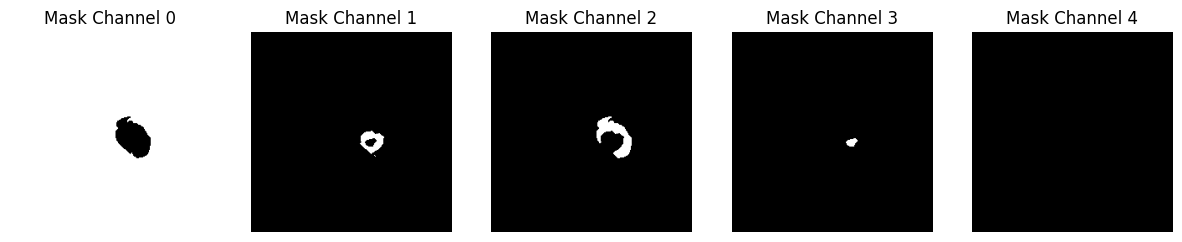

In [5]:
# Mask 시각화 함수
def visualize_mask(mask):
    num_channels = mask.shape[-1]  # 마지막 축에서 채널 개수 확인.
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
    for i in range(num_channels):
        ax = axes[i]
        ax.imshow(mask[..., i], cmap="gray")
        ax.set_title(f"Mask Channel {i}")
        ax.axis("off")
    plt.show()

with h5py.File(file_path, 'r') as file:
    mask = file['mask'][()]
    visualize_mask(mask)


Debug: image shape = (240, 240, 4)
Debug: mask shape = (240, 240, 5)
Debug: Image shape = (240, 240, 4)
Debug: Mask shape = (240, 240, 5)


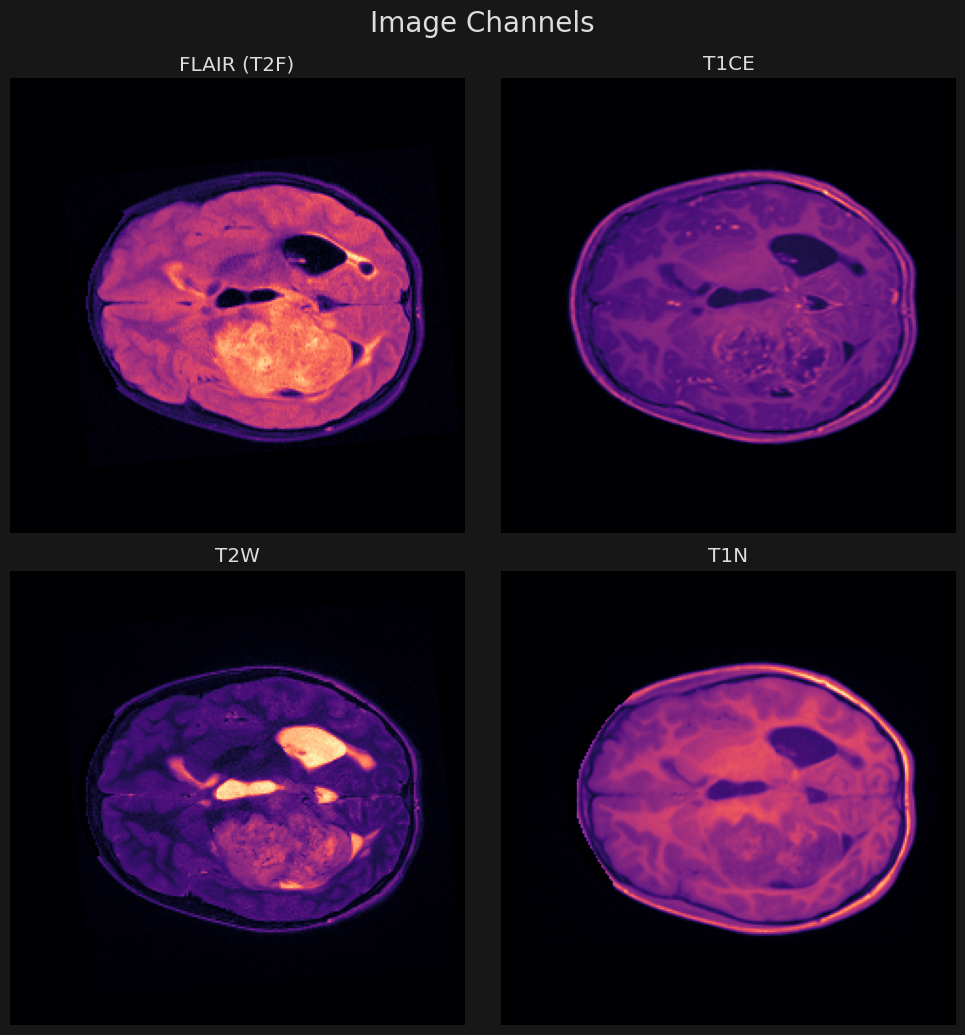

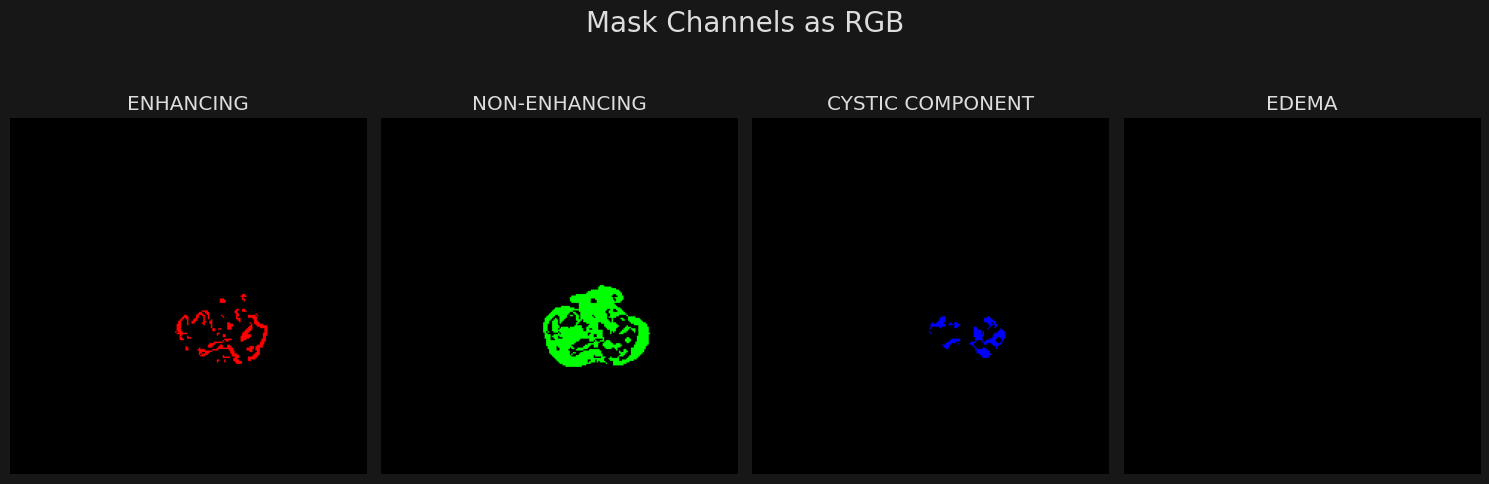

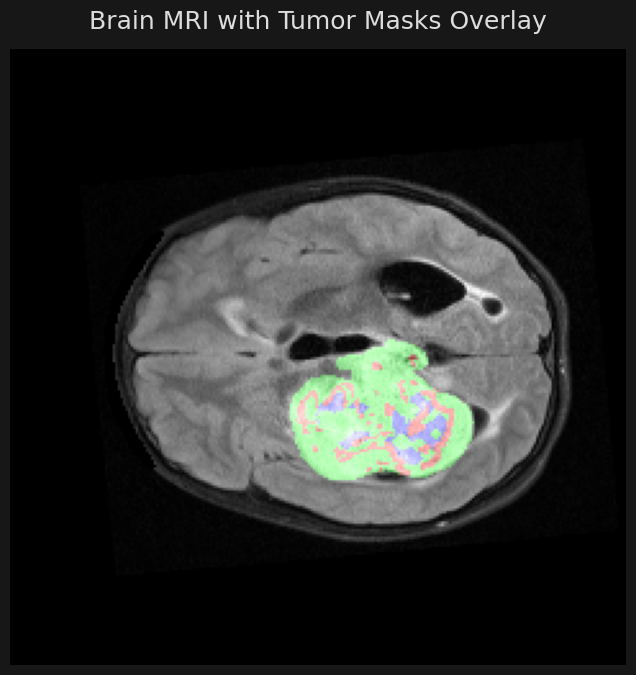

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color'] = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):

    channel_names = ['FLAIR (T2F)', 'T1CE', 'T2W', 'T1N']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[:, :, idx] 
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):

    channel_colors = [
        (1, 0, 0),  # ENHANCING - Red
        (0, 1, 0),  # NON-ENHANCING - Green
        (0, 0, 1),  # CYSTIC COMPONENT - Blue
        (1, 1, 0)   # EDEMA - Yellow
    ]

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for idx, ax in enumerate(axes):
        if idx < mask.shape[-1]:  
            mask_channel = mask[:, :, idx]
            colored_mask = np.zeros((*mask_channel.shape, 3), dtype=np.float32)
            for c in range(3): 
                colored_mask[..., c] = mask_channel * channel_colors[idx][c]
        else:  
            colored_mask = np.zeros((*mask.shape[:2], 3), dtype=np.float32)

        ax.imshow(colored_mask)
        ax.axis('off')
        ax.set_title(['ENHANCING', 'NON-ENHANCING', 'CYSTIC COMPONENT', 'EDEMA'][idx])
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.tight_layout()
    plt.show()



def overlay_masks_on_image(image, mask, title='Brain MRI with Tumor Masks Overlay'):

    t1_image = image[:, :, 0]  
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)  # Shape: (240, 240, 3)

    colors = [
        (1.0, 0.0, 0.0),  # ENHANCING - Red
        (0.0, 1.0, 0.0),  # NON-ENHANCING - Green
        (0.0, 0.0, 1.0),  # CYSTIC COMPONENT - Blue
        (1.0, 1.0, 0.0)   # EDEMA - Yellow
    ]


    if mask.shape[-1] < 4:
        padded_mask = np.zeros((*mask.shape[:2], 4), dtype=mask.dtype)
        padded_mask[:, :, :mask.shape[-1]] = mask 
        mask = padded_mask


    for i, color in enumerate(colors):
        mask_channel = mask[:, :, i]
        for c in range(3):
            rgb_image[..., c] += mask_channel * color[c] * 0.3  


    rgb_image = np.clip(rgb_image, 0, 1)


    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()



sample_file_path = os.path.join(directory, h5_files[1])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]
        print(f"Debug: {key} shape = {data[key].shape}")


image = data['image']  # (240, 240, 4)
mask = data['mask']    # (240, 240, 5)

print(f"Debug: Image shape = {image.shape}")
print(f"Debug: Mask shape = {mask.shape}")

# Display the image and masks
display_image_channels(image)
display_mask_channels_as_rgb(mask[:, :, 1:]) 
overlay_masks_on_image(image, mask[:, :, 1:]) 


In [6]:
class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic: 
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # (H, W, C) -> (C, H, W)
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
            

            for i in range(image.shape[0]):   
                min_val = np.min(image[i])     
                image[i] = image[i] - min_val  
                max_val = np.max(image[i]) + 1e-4   
                image[i] = image[i] / max_val
            

            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
        return image, mask


h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)


split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 5, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 5, 240, 240])


In [7]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.encoder_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

In [8]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)

In [8]:
class CustomSwinTransformer(nn.Module):
    def __init__(self, in_channels, embed_dim=256, depths=[2, 2, 6, 2], num_heads=[4, 4, 8, 16], window_size=7):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=2, stride=2)
        self.pos_drop = nn.Dropout(p=0.0)

        self.initial_resolution = (15 // 2, 15 // 2) 
        print(f"Initial size: {self.initial_resolution}")

        # Validate initial size
        if self.initial_resolution[0] <= 0 or self.initial_resolution[1] <= 0:
            raise ValueError(f"Initial size {self.initial_resolution} is invalid.")

        self.layers = nn.ModuleList()
        resolutions = [self.initial_resolution]
        for i in range(1, len(depths)):
            next_resolution = (resolutions[-1][0] // 2, resolutions[-1][1] // 2)
            if next_resolution[0] <= 0 or next_resolution[1] <= 0:
                break
            resolutions.append(next_resolution)

        for i, (depth, num_head, resolution) in enumerate(zip(depths, num_heads, resolutions)):
            print(f"Depth: {depth}, Num heads: {num_head}, Resolution: {resolution}")
            layer = nn.ModuleList([
                SwinTransformerBlock(dim=embed_dim, input_resolution=resolution, num_heads=num_head, window_size=window_size)
                for _ in range(depth)
            ])
            self.layers.append(layer)

        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch_embed(x)
        B, C, H, W = x.shape
        if H == 0 or W == 0:
            raise ValueError("Height or Width of the tensor after patch embedding is zero.")

        x = x.permute(0, 2, 3, 1)
        x = self.pos_drop(x)

        for layer in self.layers:
            for block in layer:
                x = block(x)

        x = self.norm(x)
        x = x.view(B, H, W, -1).permute(0, 3, 1, 2)

        x = F.interpolate(x, size=(15, 15), mode='bilinear', align_corners=False)

        return x

In [19]:
class SwinUnet(nn.Module):
    def __init__(self):
        super().__init__()

        in_channels      = 4   # Input images have 4 channels
        out_channels     = 5   # Mask has 5 channels (5 classes)
        n_filters        = 32  # Scaled down from 64 in original paper
        activation       = nn.ReLU()

        # Up and downsampling.
        self.downsample  = nn.MaxPool2d((2, 2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1 * n_filters, activation)
        self.enc_block_2 = EncoderBlock(1 * n_filters, 2 * n_filters, activation)
        self.enc_block_3 = EncoderBlock(2 * n_filters, 4 * n_filters, activation)
        self.enc_block_4 = EncoderBlock(4 * n_filters, 8 * n_filters, activation)

        # Bottleneck
        self.bottleneck  = CustomSwinTransformer(
            in_channels  = 8 * n_filters,
            embed_dim    = 256,
            depths       = [2, 2, 6, 2],
            num_heads    = [4, 4, 8, 16]
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(16 * n_filters, 4 * n_filters, activation)
        self.dec_block_3 = DecoderBlock(8 * n_filters, 2 * n_filters, activation)
        self.dec_block_2 = DecoderBlock(4 * n_filters, 1 * n_filters, activation)
        self.dec_block_1 = DecoderBlock(2 * n_filters, 1 * n_filters, activation)

        # Output projection
        self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=(1, 1), stride=1, padding=0)

    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x = self.downsample(skip_4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        x = self.upsample(x)
        x = torch.cat((x, skip_4), axis=1)  # Skip connection
        x = self.dec_block_4(x)
        x = self.upsample(x)
        x = torch.cat((x, skip_3), axis=1)  # Skip connection
        x = self.dec_block_3(x)
        x = self.upsample(x)
        x = torch.cat((x, skip_2), axis=1)  # Skip connection
        x = self.dec_block_2(x)
        x = self.upsample(x)
        x = torch.cat((x, skip_1), axis=1)  # Skip connection
        x = self.dec_block_1(x)
        x = self.output(x)
        return x


In [30]:
def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx >= batches_per_epoch:
                if verbose: print()
                break
        train_epoch_losses.append(train_epoch_loss)

        # Val step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                if verbose: print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()
                
                if val_batch_idx >= batches_per_epoch:
                    if verbose: print()
                    break
        val_epoch_losses.append(val_epoch_loss)

        if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")
        
    print("Training complete.")

    return train_epoch_losses, val_epoch_losses


# Settings for training
train_config = {
    'device': 'cuda',
    'n_epochs':          280,
    'batch_size':        32,
    'learning_rate':     1e-4,
    'batches_per_epoch': 50,
    'lr_decay_factor':   1
}

# Create UNet model and count params
model = SwinUnet()
count_parameters(model)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

Initial resolution: (7, 7)
Depth: 2, Num heads: 4, Resolution: (7, 7)
Depth: 2, Num heads: 4, Resolution: (3, 3)
Depth: 6, Num heads: 8, Resolution: (1, 1)
Total Parameters: 11,298,565

Training...
Training complete.


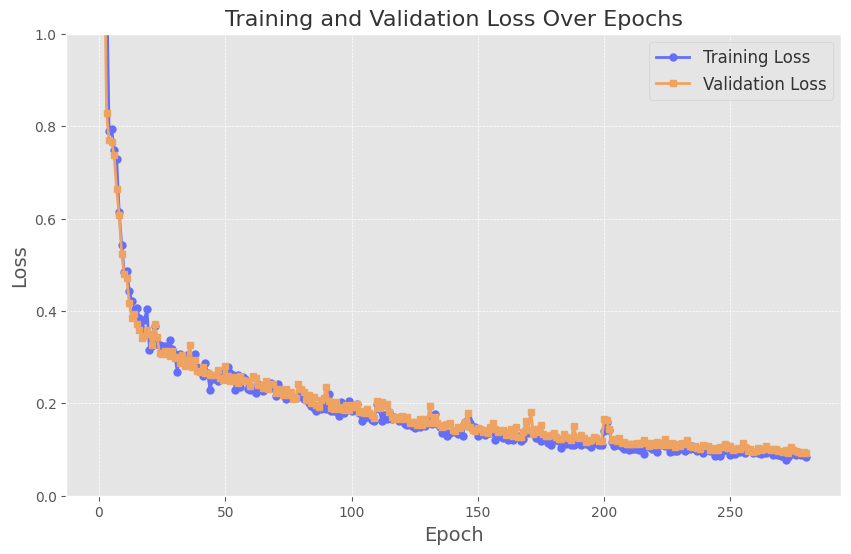

In [31]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

(240, 240, 4)
(240, 240, 5)
(240, 240, 5)


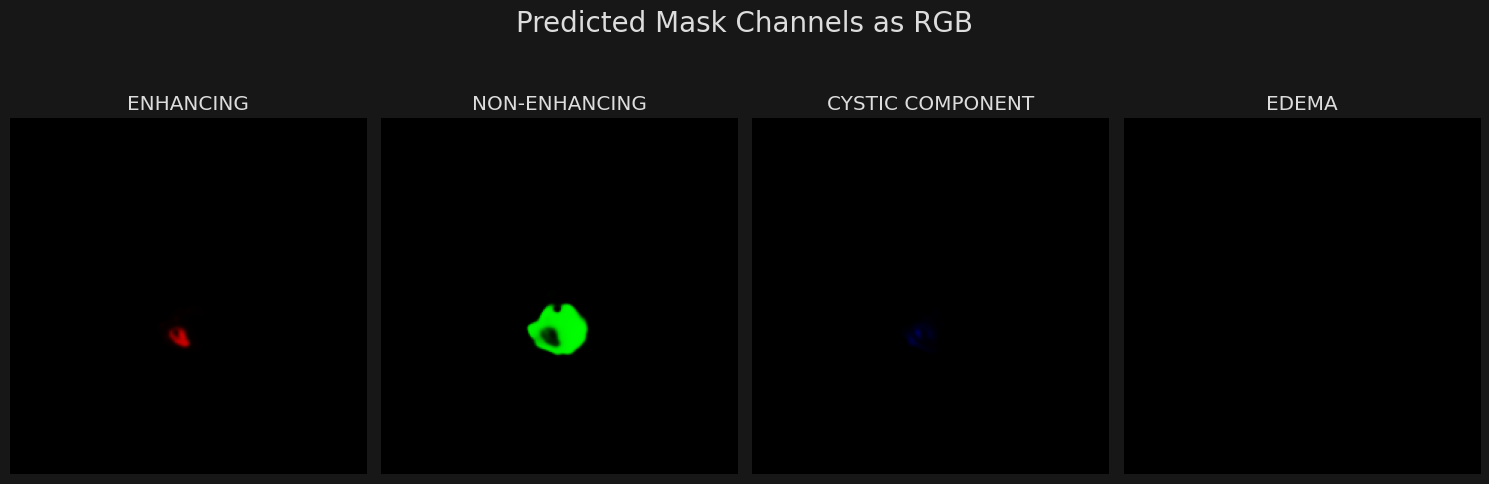

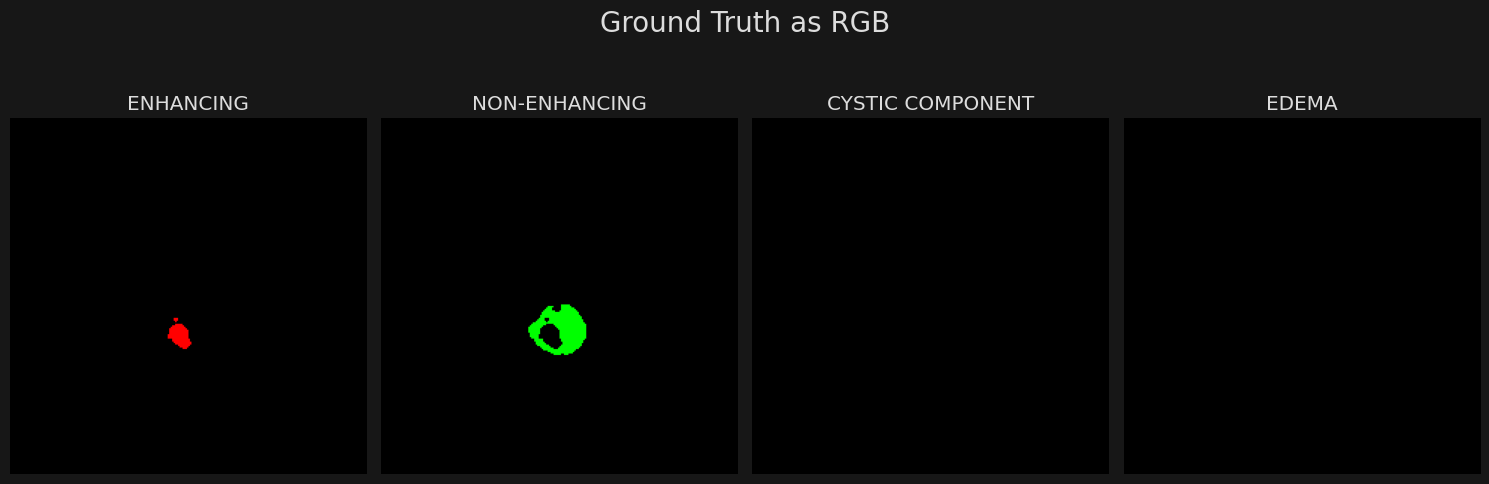

In [32]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    test_pred = torch.sigmoid(model(test_input))

    image = test_input.detach().cpu().numpy().squeeze(0)  # Shape: (4, 240, 240)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)  # Shape: (5, 240, 240)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)  # Shape: (5, 240, 240)

    image = image.transpose((2, 1, 0))
    mask_pred = mask_pred.transpose((2, 1, 0))
    mask_target = mask_target.transpose((2, 1, 0))

    print(image.shape)
    print(mask_pred.shape)
    print(mask_target.shape)

    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color'] = '#DDDDDD'

    # Display the input image
    # display_image_channels(image)

    # Display predicted and ground truth masks
    display_mask_channels_as_rgb(mask_pred[:, :, 1:], title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target[:, :, 1:], title='Ground Truth as RGB')


device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_input_iterator = iter(val_dataloader) 
test_input, test_target = next(test_input_iterator) 

# Display the test sample
display_test_sample(model, test_input[4].unsqueeze(0), test_target[4].unsqueeze(0), device)


In [33]:
torch.save(model.state_dict(), "model.pt")

In [35]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = self.projection(x) 
        x = rearrange(x, 'b c h w -> b (h w) c') 
        return x


In [36]:
class ViT(nn.Module):
    def __init__(self, embed_dim, num_patches, num_heads, num_layers, hidden_dim):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.positional_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, hidden_dim, dropout=0.1)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 c -> b 1 c', b=B)
        x = torch.cat((cls_tokens, x), dim=1) 
        x += self.positional_embeddings[:, :N + 1]

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        return x[:, 0], x[:, 1:] 

In [39]:
class ViTUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Configuration
        in_channels     = 4
        out_channels    = 5
        patch_size      = 16
        embed_dim       = 256
        num_heads       = 8
        num_layers      = 12
        hidden_dim      = 512

        # Encoder
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, embed_dim)
        num_patches = (240 // patch_size) * (240 // patch_size)
        self.transformer = ViT(embed_dim, num_patches, num_heads, num_layers, hidden_dim)

        # Decoder
        self.decoder_conv1 = nn.ConvTranspose2d(embed_dim, 128, kernel_size=2, stride=2)
        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder_conv4 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.output_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x = self.patch_embedding(x) 
        cls_token, x = self.transformer(x) 

        # Reshape token embeddings to image shape
        H, W = 240 // 16, 240 // 16
        x = rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)  

        # Decoder
        x = self.decoder_conv1(x)  # (B, 128, H*2, W*2)
        x = self.decoder_conv2(x)  # (B, 64, H*4, W*4)
        x = self.decoder_conv3(x)  # (B, 32, H*8, W*8)
        x = self.decoder_conv4(x)  # (B, 32, H*16, W*16)
        x = self.output_conv(x)    # (B, out_channels, 240, 240)

        return x


In [40]:
def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx >= batches_per_epoch:
                if verbose: print()
                break
        train_epoch_losses.append(train_epoch_loss)

        # Val step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                if verbose: print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()
                
                if val_batch_idx >= batches_per_epoch:
                    if verbose: print()
                    break
        val_epoch_losses.append(val_epoch_loss)

        if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")
        
    print("Training complete.")

    return train_epoch_losses, val_epoch_losses


# Settings for training
train_config = {
    'device': 'cuda',
    'n_epochs':          280,
    'batch_size':        32,
    'learning_rate':     1e-4,
    'batches_per_epoch': 50,
    'lr_decay_factor':   1
}

# Create UNet model and count params
model = ViTUNet()
count_parameters(model)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

Total Parameters: 6,822,821

Training...
Training complete.


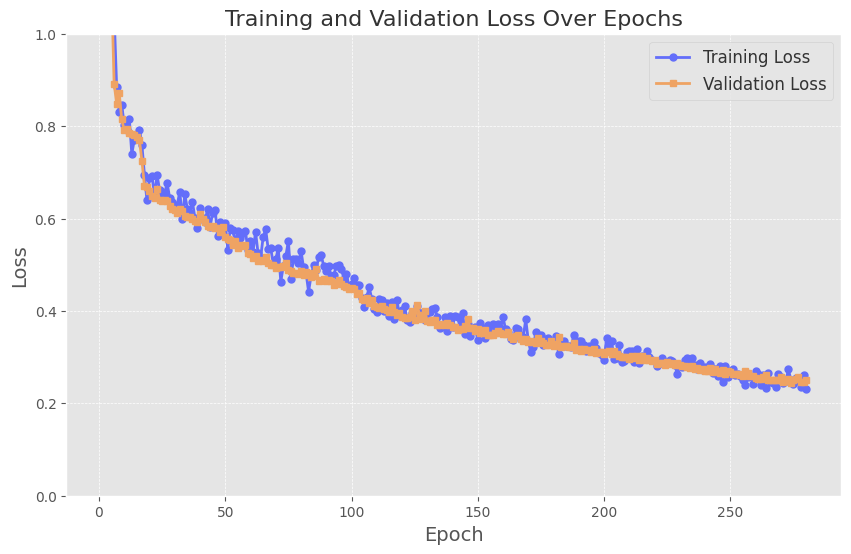

In [41]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

(240, 240, 4)
(240, 240, 5)
(240, 240, 5)


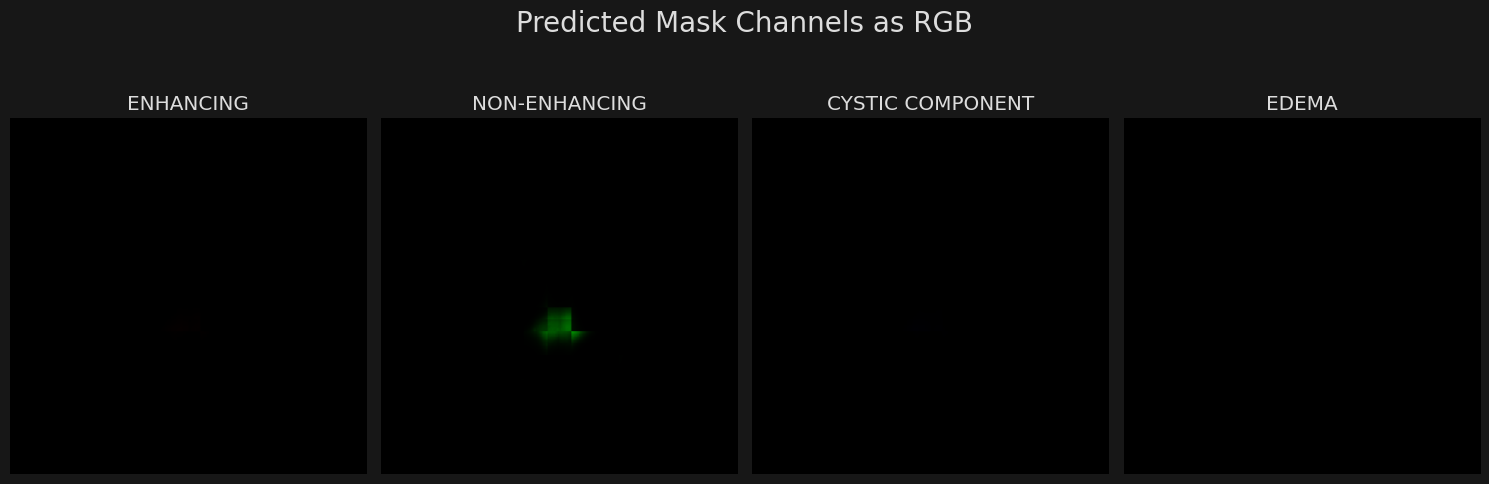

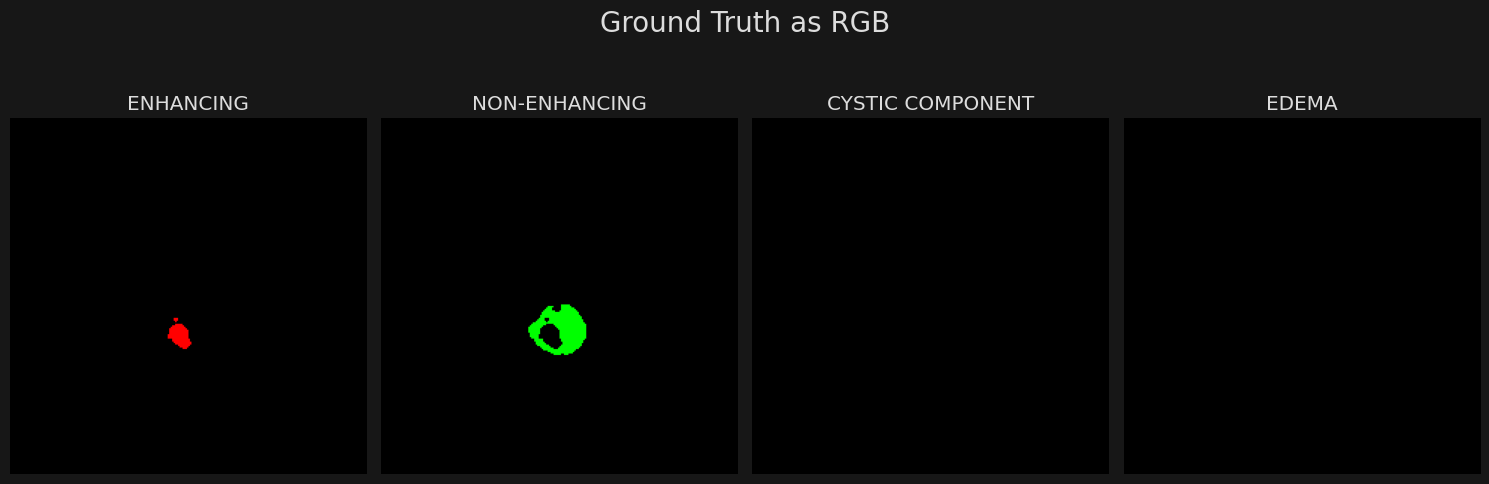

In [43]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    test_pred = torch.sigmoid(model(test_input))

    image = test_input.detach().cpu().numpy().squeeze(0)  # Shape: (4, 240, 240)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)  # Shape: (5, 240, 240)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)  # Shape: (5, 240, 240)

    image = image.transpose((2, 1, 0))
    mask_pred = mask_pred.transpose((2, 1, 0))
    mask_target = mask_target.transpose((2, 1, 0))

    print(image.shape)
    print(mask_pred.shape)
    print(mask_target.shape)

    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color'] = '#DDDDDD'

    # Display the input image
    # display_image_channels(image)

    # Display predicted and ground truth masks
    display_mask_channels_as_rgb(mask_pred[:, :, 1:], title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target[:, :, 1:], title='Ground Truth as RGB')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_input_iterator = iter(val_dataloader)  
test_input, test_target = next(test_input_iterator) 

display_test_sample(model, test_input[4].unsqueeze(0), test_target[4].unsqueeze(0), device)


In [6]:
class Simple2DCNN(nn.Module):
    def __init__(self, in_channels=4, out_channels=5, n_filters=32):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, n_filters * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_filters * 2, n_filters * 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(n_filters * 4, n_filters * 8, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(n_filters * 8, out_channels, kernel_size=1)

        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))
        x = self.pool(x)
        x = self.activation(self.conv4(x))
        x = self.pool(x)
        x = self.conv5(x)  
        x = self.upsample(x)  
        return x

In [12]:
def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        with tqdm(total=batches_per_epoch, desc=f"Epoch {epoch}/{n_epochs} - training", leave=False) as pbar:
            for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
                if verbose: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
                train_inputs = train_inputs.to(device)
                train_targets = train_targets.to(device)
                train_preds = model(train_inputs)
                train_batch_loss = loss_fn(train_preds, train_targets)
                train_epoch_loss += train_batch_loss.item()

                optimizer.zero_grad()
                train_batch_loss.backward()
                optimizer.step()

                if train_batch_idx >= batches_per_epoch:
                    if verbose: print()
                    break
        train_epoch_losses.append(train_epoch_loss)

        # Val step
        model.eval()
        val_epoch_loss = 0
        with tqdm(total=batches_per_epoch, desc=f"Epoch {epoch}/{n_epochs} - Validation", leave=False) as pbar:
            with torch.no_grad():
                for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                    if verbose: print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
                    val_inputs = val_inputs.to(device)
                    val_targets = val_targets.to(device)
                    val_preds = model(val_inputs)
                    val_batch_loss = loss_fn(val_preds, val_targets)
                    val_epoch_loss += val_batch_loss.item()
                    
                    if val_batch_idx >= batches_per_epoch:
                        if verbose: print()
                        break
        val_epoch_losses.append(val_epoch_loss)

        if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")
        
    print("Training complete.")

    return train_epoch_losses, val_epoch_losses


# Settings for training
train_config = {
    'device': 'cuda',
    'n_epochs':          280,
    'batch_size':        32,
    'learning_rate':     1e-4,
    'batches_per_epoch': 50,
    'lr_decay_factor':   1
}

# Create UNet model and count params
model = Simple2DCNN()
count_parameters(model)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

Total Parameters: 389,989

Training...


Training complete.


In [1]:
from torchsummary import summary

model = Simple2DCNN()
summary(model, input_size=(4, 240, 240))

NameError: name 'model' is not defined

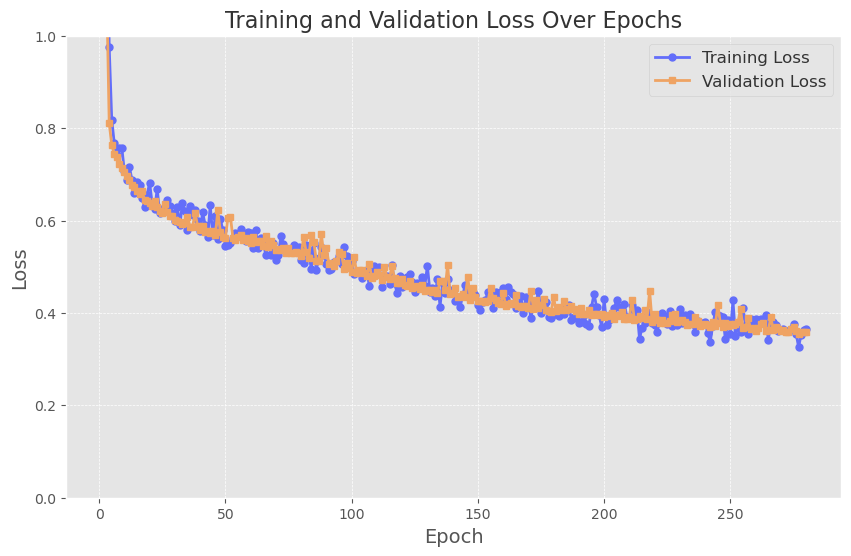

In [13]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

(240, 240, 4)
(240, 240, 5)
(240, 240, 5)


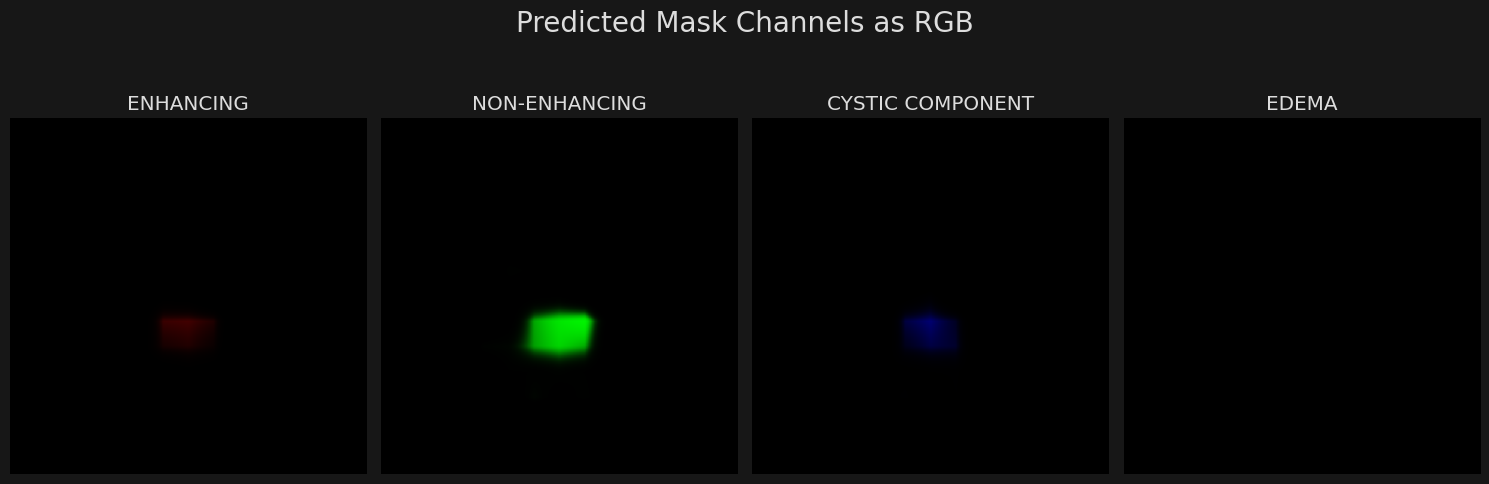

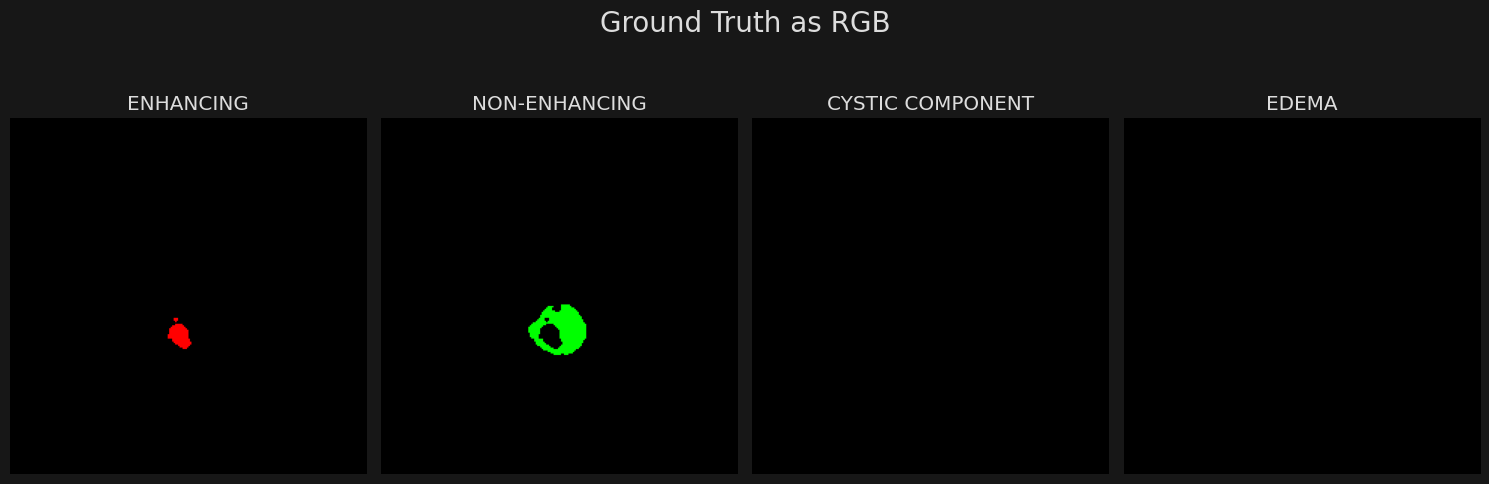

: 

In [14]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    test_pred = torch.sigmoid(model(test_input))

    image = test_input.detach().cpu().numpy().squeeze(0)  # Shape: (4, 240, 240)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)  # Shape: (5, 240, 240)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)  # Shape: (5, 240, 240)

    image = image.transpose((2, 1, 0))
    mask_pred = mask_pred.transpose((2, 1, 0))
    mask_target = mask_target.transpose((2, 1, 0))

    print(image.shape)
    print(mask_pred.shape)
    print(mask_target.shape)

    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color'] = '#DDDDDD'

    # Display the input image
    # display_image_channels(image)

    # Display predicted and ground truth masks
    display_mask_channels_as_rgb(mask_pred[:, :, 1:], title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target[:, :, 1:], title='Ground Truth as RGB')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_input_iterator = iter(val_dataloader)  
test_input, test_target = next(test_input_iterator) 

display_test_sample(model, test_input[4].unsqueeze(0), test_target[4].unsqueeze(0), device)
